In [43]:
from tfcomb import CombObj, DiffCombObj, utils
import os
import pathlib
import pandas as pd
import numpy as np
'''
Constants for this script
'''

#genome_path="../testdaten/hg19_masked.fa"
genome_path="../testdaten/homo_sapiens.104.mainChr.fa"

main_jaspar_file="../testdaten/JASPAR2020_CORE_vertebrates.meme" 

# path where market basket analyses for cluster are put.
result_path="./results/wp2/"
main_analysis_path=f"{result_path}main/"
differential_analysis_path=f"{result_path}diff_analysis/"

differential_analysis_selection_path=f"{differential_analysis_path}selection/"
answers_path=f"{result_path}answers/"

### folder of wp2, where the clusters are
#path_to_clusters="../testdaten/wp2/"
#path_to_clusters="/mnt/workspace_stud/stud3/WP6_data/"
path_to_clusters="/mnt/workspace_stud/stud4/WP6_data/"

# create result folders 
if not os.path.exists(result_path):
     pathlib.Path(result_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(main_analysis_path):
     pathlib.Path(main_analysis_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(differential_analysis_path):
     pathlib.Path(differential_analysis_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(answers_path):
     pathlib.Path(answers_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(differential_analysis_selection_path):
     pathlib.Path(differential_analysis_selection_path).mkdir(parents=True, exist_ok=True)

if not os.path.exists(genome_path):
    print(f"ERROR: path {genome_path} does not exist")

if not os.path.exists(main_jaspar_file):
    print(f"ERROR: path {main_jaspar_file} does not exist")

if not os.path.exists(path_to_clusters):
    print(f"ERROR: path {path_to_clusters} does not exist")


In [2]:
def do_market_basket_analyses_for_cell_cluster(cell_cluster_name: str, cell_cluster_path:str):
    '''
        Does market basket analyses.
    '''
    comb = CombObj()
    comb.TFBS_from_motifs(regions= cell_cluster_path,
                   motifs=main_jaspar_file,
                   genome=genome_path,
                   threads=4)
    
    print(f'Start market basket analyses for cell-cluster/type: {cell_cluster_name}')
    comb.market_basket(threads=10)
    if len(comb.rules) <= 0:
        print(f'Could not find TF-cooccurences for cell-cluster/type: {cell_cluster_name}')
        return
    print(f'Finished market basket analyses for cell-cluster/type: {cell_cluster_name}')
    print(f'Found rules: {len(comb.rules)}')
    comb.to_pickle(f'{main_analysis_path}{cell_cluster_name}.pkl')
    print(f'Saved: {main_analysis_path}{cell_cluster_name}.pkl')

In [3]:
def read_in_file_names_of_folder(rel_path:str):
    return [f for f in os.listdir(rel_path) if os.path.isfile(os.path.join(rel_path, f))]

cluster_file_names = read_in_file_names_of_folder(rel_path=path_to_clusters)
print(cluster_file_names)





['right-lobe-of-liver.10.bed', 'right-lobe-of-liver.11.bed', 'right-lobe-of-liver.12.bed', 'right-lobe-of-liver.14.bed', 'right-lobe-of-liver.15.bed', 'right-lobe-of-liver.16.bed', 'right-lobe-of-liver.17.bed', 'right-lobe-of-liver.18.bed', 'right-lobe-of-liver.1.bed', 'right-lobe-of-liver.2.bed', 'right-lobe-of-liver.3.bed', 'right-lobe-of-liver.4.bed', 'right-lobe-of-liver.5.bed', 'right-lobe-of-liver.6.bed', 'right-lobe-of-liver.7.bed', 'right-lobe-of-liver.8.bed']


In [ ]:
# Has to be tested as soon as wp2 generates new .bed files
for file_name in cluster_file_names:
    cluster_name = file_name.split('.bed')[0]
    print(cluster_name)
    print(file_name)
    cluster_path=f"{path_to_clusters}{file_name}"
    do_market_basket_analyses_for_cell_cluster(cell_cluster_name=cluster_name, cell_cluster_path=cluster_path)

    

# Analysis

### Differential Analysis

In [4]:
# mb market basket analysis
files_main_mb= read_in_file_names_of_folder(rel_path=main_analysis_path)
print(f"Count of Files: {len(files_main_mb)}")
print(f"Files: {files_main_mb}")


Count of Files: 16
Files: ['right-lobe-of-liver.10.pkl', 'right-lobe-of-liver.11.pkl', 'right-lobe-of-liver.12.pkl', 'right-lobe-of-liver.14.pkl', 'right-lobe-of-liver.15.pkl', 'right-lobe-of-liver.16.pkl', 'right-lobe-of-liver.17.pkl', 'right-lobe-of-liver.18.pkl', 'right-lobe-of-liver.1.pkl', 'right-lobe-of-liver.2.pkl', 'right-lobe-of-liver.3.pkl', 'right-lobe-of-liver.4.pkl', 'right-lobe-of-liver.5.pkl', 'right-lobe-of-liver.6.pkl', 'right-lobe-of-liver.7.pkl', 'right-lobe-of-liver.8.pkl']


In [5]:
# Diff analysis for all clusters of a tissue:
# TODO: what should be compared ? All of a Tissue? or All? Naming?
tissue_name = 'right-lobe-of-liver'
combObj_to_compare = []
for i, file in enumerate(files_main_mb):
    print(file)
    name_i = file.split('.pkl')[0]
    tissue_name = file.split('.')[0]
    obj = CombObj().from_pickle(f"{main_analysis_path}{file}")
    obj.set_prefix(name_i)
    #print(obj)
    combObj_to_compare.append(obj)
    
compare_obj = DiffCombObj(combObj_to_compare, measure="cosine", join="outer", fillna=True)
compare_obj.to_pickle(f'{differential_analysis_path}{tissue_name}.pkl')
compare_obj.normalize()
compare_obj.calculate_foldchanges()
compare_obj.to_pickle(f'{differential_analysis_path}{tissue_name}_normalized.pkl')
#selection does not work?
#selected_std = compare_obj.select_rules()
#selected_std.to_pickle(f'{differential_analysis_selection_path}{tissue_name}.pkl')
print("Done differential analysis")

right-lobe-of-liver.10.pkl
right-lobe-of-liver.11.pkl
right-lobe-of-liver.12.pkl
right-lobe-of-liver.14.pkl
right-lobe-of-liver.15.pkl
right-lobe-of-liver.16.pkl
right-lobe-of-liver.17.pkl
right-lobe-of-liver.18.pkl
right-lobe-of-liver.1.pkl
right-lobe-of-liver.2.pkl
right-lobe-of-liver.3.pkl
right-lobe-of-liver.4.pkl
right-lobe-of-liver.5.pkl
right-lobe-of-liver.6.pkl
right-lobe-of-liver.7.pkl
right-lobe-of-liver.8.pkl
INFO: Calculating foldchange for contrast: right-lobe-of-liver.10 / right-lobe-of-liver.11
INFO: Calculating foldchange for contrast: right-lobe-of-liver.10 / right-lobe-of-liver.12
INFO: Calculating foldchange for contrast: right-lobe-of-liver.10 / right-lobe-of-liver.14
INFO: Calculating foldchange for contrast: right-lobe-of-liver.10 / right-lobe-of-liver.15
INFO: Calculating foldchange for contrast: right-lobe-of-liver.10 / right-lobe-of-liver.16
INFO: Calculating foldchange for contrast: right-lobe-of-liver.10 / right-lobe-of-liver.17
INFO: Calculating foldchange f

INFO: Calculating foldchange for contrast: right-lobe-of-liver.18 / right-lobe-of-liver.4
INFO: Calculating foldchange for contrast: right-lobe-of-liver.18 / right-lobe-of-liver.5
INFO: Calculating foldchange for contrast: right-lobe-of-liver.18 / right-lobe-of-liver.6
INFO: Calculating foldchange for contrast: right-lobe-of-liver.18 / right-lobe-of-liver.7
INFO: Calculating foldchange for contrast: right-lobe-of-liver.18 / right-lobe-of-liver.8
INFO: Calculating foldchange for contrast: right-lobe-of-liver.1 / right-lobe-of-liver.2
INFO: Calculating foldchange for contrast: right-lobe-of-liver.1 / right-lobe-of-liver.3
INFO: Calculating foldchange for contrast: right-lobe-of-liver.1 / right-lobe-of-liver.4
INFO: Calculating foldchange for contrast: right-lobe-of-liver.1 / right-lobe-of-liver.5
INFO: Calculating foldchange for contrast: right-lobe-of-liver.1 / right-lobe-of-liver.6
INFO: Calculating foldchange for contrast: right-lobe-of-liver.1 / right-lobe-of-liver.7
INFO: Calculatin

/home/stud6/.conda/envs/tfcomb_env/lib/python3.7/site-packages/tfcomb/objects.py:1894: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.rules[log2_col] = np.log2((p1_values + pseudo) / (p2_values + pseudo))


INFO: Calculating foldchange for contrast: right-lobe-of-liver.6 / right-lobe-of-liver.7
INFO: Calculating foldchange for contrast: right-lobe-of-liver.6 / right-lobe-of-liver.8
INFO: Calculating foldchange for contrast: right-lobe-of-liver.7 / right-lobe-of-liver.8
INFO: The calculated log2fc's are found in the rules table (<DiffCombObj>.rules)
Done differential analysis


In [ ]:
compare_obj

In [ ]:
compare_obj.rules

INFO: Selecting rules for contrast: ('right-lobe-of-liver.10', 'right-lobe-of-liver.11')
INFO: measure_threshold is None; trying to calculate optimal threshold
INFO: mean_threshold is None; trying to calculate optimal threshold
INFO: Creating subset of rules using thresholds


,TF1,TF2,right-lobe-of-liver.10_cosine,right-lobe-of-liver.11_cosine,right-lobe-of-liver.12_cosine,right-lobe-of-liver.14_cosine,right-lobe-of-liver.15_cosine,right-lobe-of-liver.16_cosine,right-lobe-of-liver.17_cosine,right-lobe-of-liver.18_cosine,...,right-lobe-of-liver.4/right-lobe-of-liver.5_cosine_log2fc,right-lobe-of-liver.4/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.4/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.4/right-lobe-of-liver.8_cosine_log2fc,right-lobe-of-liver.5/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.5/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.5/right-lobe-of-liver.8_cosine_log2fc,right-lobe-of-liver.6/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.6/right-lobe-of-liver.8_cosine_log2fc,right-lobe-of-liver.7/right-lobe-of-liver.8_cosine_log2fc


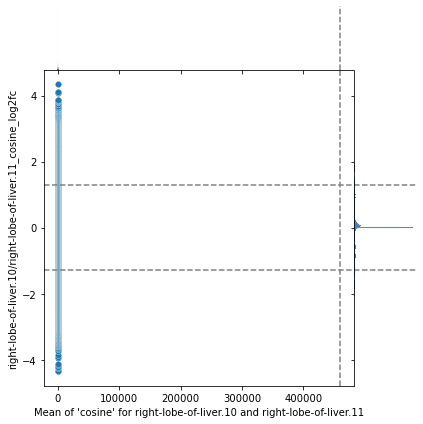

In [79]:

selected.rules

## Old: Self implemented - Differential analysis - comparing each cluster

In [ ]:
# Diff analysis between each cluster:
for i, file in enumerate(files_main_mb):
    print(file)
    name_i = file.split('.pkl')[0]
    
    for j in range(i + 1, len(files_main_mb), 1):
        file_j = files_main_mb[j]
        name_j = file_j.split('.pkl')[0]
        print(j)
        print(name_j)
        A = CombObj().from_pickle(f"{main_analysis_path}{file}")
        print(A)
        A.set_prefix(name_i)
        B = CombObj().from_pickle(f"{main_analysis_path}{file_j}")
        print(B)
        B.set_prefix(name_j)
        compare_obj = A.compare(B)
        compare_obj.to_pickle(f'{differential_analysis_path}{name_i}__{name_j}.pkl')
        
        selected_std = compare_obj.select_rules()
        
        #TODO: Save autamatically generated thresholds
        # utils.get_threshold(new.rules.iloc[:,4], 'both', percent=0.05)
        # logfc threshold (-xxx , +xxx)
        #  utils.get_threshold(new.rules.iloc[:,2:4].mean(axis=1), 'upper', percent=0.05)
        # cosine threshold
        selected_std.to_pickle(f'{differential_analysis_selection_path}{name_i}__{name_j}.pkl')
        
        break;
        
        
print("Done differential analysis")

## Specific analysis:
### Question:
Does the cluster 'right-lobe-of-liver.1.pkl' have specific tf-co-occurences, which can´t be found in the other clusters of the right-lobe-of-liver. ? Which are those tf-co and how many are there?
####  Steps:
    - Take all differential mb-analysis of cluster one. Merge them to a pandas dataframe.
    - Remove All diff tf-co´s which are found twice in the analysis.
    
    TODO:
    - simplify_rules für die selection einbauen
    - classify neg_pos foldchanges 'positiv', 'negativ'
    - Merge Diff_analysis für einen gesamten cluster zu großen dataframe (outer join, nicht inner join wie jetzt), um das dann auszuwerten 
    

In [6]:
# Analyses with whole diffcombj
diff_file_names=read_in_file_names_of_folder(rel_path=differential_analysis_path)

normalized_diff_objects = []
diff_objects = []

for file in diff_file_names:
    obj = DiffCombObj().from_pickle(f"{differential_analysis_path}{file}")
    if "normalized" in file:
        normalized_diff_objects.append(obj)
    else:
        diff_objects.append(obj)

print(normalized_diff_objects)
print(diff_objects) 

normalized_dfs = []
for obj in normalized_diff_objects:
    normalized_dfs.append(obj.rules)
print("Done: Preparing rules of DiffObj")    

Done: Preparing rules of DIFFObj


In [83]:
obj = normalized_diff_objects[0]
t = normalized_diff_objects[0].rules
t[t['right-lobe-of-liver.10_cosine'] > 0.7]
obj.rules

,TF1,TF2,right-lobe-of-liver.10_cosine,right-lobe-of-liver.11_cosine,right-lobe-of-liver.12_cosine,right-lobe-of-liver.14_cosine,right-lobe-of-liver.15_cosine,right-lobe-of-liver.16_cosine,right-lobe-of-liver.17_cosine,right-lobe-of-liver.18_cosine,...,right-lobe-of-liver.4/right-lobe-of-liver.5_cosine_log2fc,right-lobe-of-liver.4/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.4/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.4/right-lobe-of-liver.8_cosine_log2fc,right-lobe-of-liver.5/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.5/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.5/right-lobe-of-liver.8_cosine_log2fc,right-lobe-of-liver.6/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.6/right-lobe-of-liver.8_cosine_log2fc,right-lobe-of-liver.7/right-lobe-of-liver.8_cosine_log2fc
E2F3-E2F1,E2F3,E2F1,0.000000,0.056349,0.078676,0.0,0.062911,0.0,0.0,0.057648,...,4.386501,4.386501,4.386501,-1.299556,0.0,0.0,-5.686057,0.0,-5.686057,-5.686057
E2F1-E2F3,E2F1,E2F3,0.000000,0.056349,0.078676,0.0,0.062911,0.0,0.0,0.057648,...,4.386501,4.386501,4.386501,-1.299556,0.0,0.0,-5.686057,0.0,-5.686057,-5.686057
E2F2-E2F1,E2F2,E2F1,0.000000,0.055520,0.068129,0.0,0.058992,0.0,0.0,0.055021,...,4.346155,4.346155,4.346155,-1.298184,0.0,0.0,-5.644340,0.0,-5.644340,-5.644340
E2F1-E2F2,E2F1,E2F2,0.000000,0.055520,0.068129,0.0,0.058992,0.0,0.0,0.055021,...,4.346155,4.346155,4.346155,-1.298184,0.0,0.0,-5.644340,0.0,-5.644340,-5.644340
E2F2-E2F3,E2F2,E2F3,0.000000,0.052115,0.070327,0.0,0.053347,0.0,0.0,0.050187,...,4.249391,4.249391,4.249391,-1.116953,0.0,0.0,-5.366344,0.0,-5.366344,-5.366344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAX-OVOL1,RAX,OVOL1,0.047339,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.026235,...,3.120570,3.120570,3.120570,3.120570,0.0,0.0,0.000000,0.0,0.000000,0.000000
MYBL1-TFAP4var.2,MYBL1,TFAP4var.2,0.047388,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.024333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
TFAP4var.2-MYBL1,TFAP4var.2,MYBL1,0.047388,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.024333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
OVOL1-HESX1,OVOL1,HESX1,0.056188,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.031990,...,3.432710,3.432710,3.432710,3.432710,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [90]:
def get_significant_log2fc_rules(df:pd.DataFrame, threshold_percent=0.05):
    reduced_df = df.copy(deep=True)
    for col in df.columns:
        measure_threshold = utils.get_threshold(df[col], "both", percent=threshold_percent)
        upper_threshold = measure_threshold[1]
        lower_threshold = measure_threshold[0]
        reduced_df = reduced_df[(reduced_df[col] > upper_threshold) | (reduced_df[col] < lower_threshold)]
    return reduced_df

In [92]:
results_df = []
for df in normalized_dfs:
    for i, file in enumerate(files_main_mb):
        # print(file)
        cluster_name = file.split('.pkl')[0]
        print(cluster_name)
        
        # reduce to relevant columns of cluster
        cluster_cols = list(filter(lambda x: f'{cluster_name}' in x , df.columns))
        # NOT WORKING: logfc_cluster_cols = list(filter(lambda x: (f'{cluster_name}/' || f'/{cluster_name}') in x , cluster_cols)) 
        # This is important: for right-lob-of-liver-1 
        logfc_cluster_cols = []
        for entry in cluster_cols:
            if (f'{cluster_name}/' in entry) or (f'/{cluster_name}_cosine_log2fc' in entry):
                logfc_cluster_cols.append(entry)
        
        #print(logfc_cluster_cols)
        print(len(logfc_cluster_cols))
        #print(logfc_cluster_cols)
        
        reduced_df = df[logfc_cluster_cols]
        print(f'Initial Count: {reduced_df.shape}')
        
        # Remove 0.00 or Nan values, which indicate that there are no differences between cluster
        val_counts = reduced_df[~reduced_df.isin([0])].count(axis=1).sort_values()
        #print(tmp_val_counts)
        # Selection if tf-tf occures in each cluster etc. ()
        selction_count = len(logfc_cluster_cols) # z.B 15 could be varyied
        tfs_occ = val_counts[val_counts >= selction_count].index

        result = reduced_df.loc[tfs_occ]
        print(f'Specific: {result.shape}')
        
        significants = get_significant_log2fc_rules(result, threshold_percent=0.05)
        results_df.append(significants)
        print(f'Specific significant: {significants.shape}')
         

right-lobe-of-liver.10
15
Initial Count: (483427, 15)
significants: (92, 15)
Results: (92, 15)
right-lobe-of-liver.11
15
Initial Count: (483427, 15)
significants: (62, 15)
Results: (62, 15)
right-lobe-of-liver.12
15
Initial Count: (483427, 15)
significants: (1983, 15)
Results: (1983, 15)
right-lobe-of-liver.14
15
Initial Count: (483427, 15)
significants: (3826, 15)
Results: (3826, 15)
right-lobe-of-liver.15
15
Initial Count: (483427, 15)
significants: (185, 15)
Results: (185, 15)
right-lobe-of-liver.16
15
Initial Count: (483427, 15)
significants: (84, 15)
Results: (84, 15)
right-lobe-of-liver.17
15
Initial Count: (483427, 15)
significants: (270, 15)
Results: (270, 15)
right-lobe-of-liver.18
15
Initial Count: (483427, 15)
significants: (118, 15)
Results: (118, 15)
right-lobe-of-liver.1
15
Initial Count: (483427, 15)
significants: (41, 15)
Results: (41, 15)
right-lobe-of-liver.2
15
Initial Count: (483427, 15)
significants: (71, 15)
Results: (71, 15)
right-lobe-of-liver.3
15
Initial Count

In [94]:
df1 = results_df[0]
df1

,right-lobe-of-liver.10/right-lobe-of-liver.11_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.12_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.14_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.15_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.16_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.17_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.18_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.2_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.3_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.4_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.5_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.10/right-lobe-of-liver.8_cosine_log2fc
GCM2-SPDEF,-2.191334,-2.930233,-4.702536,-2.399306,-2.576949,-2.732146,-2.470670,-2.072742,-1.791667,-2.287722,-2.229923,-2.907592,-3.594869,-3.030491,-3.159467
TEAD2-BARHL2,3.165490,3.165490,3.165490,3.165490,3.165490,3.165490,3.165490,1.843176,3.165490,3.165490,3.165490,3.165490,3.165490,3.165490,3.165490
GMEB2-RORAvar.2,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509
RORAvar.2-GMEB2,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509,3.115509
PITX3-MYBL2,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217,3.067217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MXI1-HOXA9,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182,2.810182
OVOL1-VEZF1,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899
VEZF1-OVOL1,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899,2.803899
HOXB6-HOXA9,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880,2.881880


In [ ]:
# filtering if, nan values occure
filtered = df[logfc_cluster_cols]

val_counts = filtered.count(axis=1).sort_values()
#print(val_counts)
tfs_occ = val_counts[val_counts >=16].index
final = filtered.loc[tfs_occ]

In [84]:
df = normalized_dfs[0]
cluster_name = "right-lobe-of-liver.1"
cluster_cols = list(filter(lambda x: f'{cluster_name}' in x , df.columns))
# NOT WORKING: logfc_cluster_cols = list(filter(lambda x: (f'{cluster_name}/' || f'/{cluster_name}') in x , cluster_cols)) 
# This is important: for right-lob-of-liver-1 
logfc_cluster_cols = []
for entry in cluster_cols:
    if (f'{cluster_name}/' in entry) or (f'/{cluster_name}_cosine_log2fc' in entry):
        logfc_cluster_cols.append(entry)
        
tmp = df[logfc_cluster_cols]
# wtf, tmp[~tmp.isin([0])]??
tmp_val_counts = tmp[~tmp.isin([0])].count(axis=1).sort_values()
#print(tmp_val_counts)
tmp_tfs_occ = tmp_val_counts[tmp_val_counts == len(logfc_cluster_cols)].index
result = tmp.loc[tmp_tfs_occ]
print(result.shape)
result

(380570, 15)


,right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.12/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.14/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.15/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.16/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.17/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.18/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.2_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.3_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.4_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.5_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.8_cosine_log2fc
KLF11-NHLH2,0.218805,0.110852,-0.091880,-0.047119,0.132801,0.167874,0.038536,0.031788,-0.127198,-0.180857,-0.147343,-0.158943,0.294146,0.170171,-0.305075
Arid3a-ZNF354C,0.012972,-0.094893,-0.274396,-2.066641,-0.090419,-0.103787,0.194772,-0.022511,-0.016752,0.072177,0.082504,0.286039,1.010992,0.149378,0.562475
TFEC-TBX18,-0.281481,-0.389340,-1.064988,-1.064988,-1.064988,-0.172982,0.815799,-1.064988,0.999051,1.064988,1.064988,-0.393526,1.064988,1.064988,1.064988
Rxra-MAXMYC,0.476597,0.368735,-0.901996,-0.901996,-0.901996,-0.901996,0.054573,-0.101313,0.212837,0.901996,0.242042,-0.782478,0.901996,0.901996,0.901996
Zfx-MYB,-0.541627,-0.649572,-0.307877,-1.964773,0.111886,-0.500099,0.277856,-0.538062,-0.248723,0.054222,0.619194,0.191677,-0.430340,-0.438408,0.156555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOXA2-RAX2,0.321930,0.420526,-0.994044,-0.994044,-0.994044,-0.994044,-0.994044,0.747482,0.320524,0.994044,0.994044,0.994044,0.994044,0.994044,0.994044
HOXA2-Msx3,0.321930,0.420526,-0.994044,-0.994044,-0.994044,-0.994044,-0.994044,0.747482,0.320524,0.994044,0.994044,0.994044,0.994044,0.994044,0.994044
HOXA2-MSX2,0.321930,0.420526,-0.994044,-0.994044,-0.994044,-0.994044,-0.994044,0.747482,0.320524,0.994044,0.994044,0.994044,0.994044,0.994044,0.994044
GSX2-SHOX,0.321930,0.420526,-0.994044,-0.994044,-0.994044,-0.994044,-0.994044,0.747482,0.320524,0.994044,0.994044,0.994044,0.994044,0.994044,0.994044


In [49]:
measure_threshold_1 = utils.get_threshold(result['right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc']
                                        , "both", percent=0.05)
measure_threshold_2 = utils.get_threshold(result['right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc']
                                        , "both", percent=0.05)
print(f'1: {measure_threshold_1}')
print(f'1: {measure_threshold_2}')

1: (-1.4396379109398885, 1.2188744595008525)
1: (-1.5139206847178812, 1.1252831521774205)


In [53]:
measure_threshold_1[1]

1.2188744595008525

In [55]:
#t[t['right-lobe-of-liver.10_cosine'] > 0.7]
reduced_result_1 = result[(result['right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc'] > measure_threshold_1[1]) | (result['right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc'] < measure_threshold_1[0])]
reduced_result = reduced_result_1[(reduced_result_1['right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc'] > measure_threshold_2[1]) | (reduced_result_1['right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc'] < measure_threshold_2[0])]
reduced_result

,right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.12/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.14/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.15/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.16/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.17/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.18/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.2_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.3_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.4_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.5_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.8_cosine_log2fc
ZNF75D-INSM1,1.318495,1.210551,1.926919,-0.117341,0.942183,0.935486,1.680265,0.870199,-0.680665,-0.813263,-0.834262,-1.154433,-2.477505,-1.924034,0.117341
INSM1-ZNF75D,1.318495,1.210551,1.926919,-0.117341,0.942183,0.935486,1.680265,0.870199,-0.680665,-0.813263,-0.834262,-1.154433,-2.477505,-1.924034,0.117341
Crx-ETV1,-1.516786,-1.625040,-2.669383,-2.669383,-1.895486,-0.773137,-1.162382,-1.973425,1.719584,0.599549,0.942578,1.340432,2.669383,0.776304,2.669383
ETV1-Crx,-1.516786,-1.625040,-2.669383,-2.669383,-1.895486,-0.773137,-1.162382,-1.973425,1.719584,0.599549,0.942578,1.340432,2.669383,0.776304,2.669383
FOS-PAX3var.2,1.881426,1.773786,-0.913667,-0.913667,-0.913667,-0.913667,0.956528,-0.913667,-0.813948,-0.888762,0.913667,0.913667,0.913667,0.913667,0.913667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Foxq1-TEF,-2.108754,-2.010595,-3.232573,-3.232573,-1.797168,-3.232573,-1.512032,-0.936698,2.869648,3.232573,3.232573,3.232573,3.232573,3.232573,3.232573
TEF-Foxq1,-2.108754,-2.010595,-3.232573,-3.232573,-1.797168,-3.232573,-1.512032,-0.936698,2.869648,3.232573,3.232573,3.232573,3.232573,3.232573,3.232573
DMRT3-SOX21,1.379939,1.478875,1.517233,-1.001940,1.804808,0.914879,0.889117,0.690861,-1.229940,-0.649352,-0.682651,-1.505437,1.001940,-2.374180,-2.320093
SOX21-DMRT3,1.379939,1.478875,1.517233,-1.001940,1.804808,0.914879,0.889117,0.690861,-1.229940,-0.649352,-0.682651,-1.505437,1.001940,-2.374180,-2.320093


In [74]:
def get_significant_log2fc_rules(df:pd.DataFrame, threshold_percent=0.05):
    reduced_df = df.copy(deep=True)
    for col in result.columns:
        measure_threshold = utils.get_threshold(df[col], "both", percent=threshold_percent)
        upper_threshold = measure_threshold[1]
        lower_threshold = measure_threshold[0]
        reduced_df = reduced_df[(reduced_df[col] > upper_threshold) | (reduced_df[col] < lower_threshold)]
    return reduced_df

f = get_significant_log2fc_rules(result)
f

,right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.12/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.14/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.15/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.16/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.17/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.18/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.2_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.3_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.4_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.5_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.8_cosine_log2fc
POU6F1-POU6F1,-1.809898,-3.618891,-3.618891,-3.618891,-3.618891,-3.618891,-3.618891,-3.618891,3.618891,3.618891,3.618891,3.618891,3.618891,3.618891,3.618891
GRHL1-BCL6B,-1.468803,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,2.055506,2.901701,2.901701,2.901701,2.901701,2.901701,2.901701
BCL6B-GRHL1,-1.468803,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,2.055506,2.901701,2.901701,2.901701,2.901701,2.901701,2.901701
OTX1-OTX1,-3.099020,-3.099020,-3.099020,-3.099020,-3.099020,-3.099020,-3.099020,-3.099020,3.099020,3.099020,3.099020,3.099020,3.099020,3.099020,3.099020
HMBOX1-OVOL2,-3.084301,-3.084301,-3.084301,-3.084301,-3.084301,-3.084301,-3.084301,-3.084301,3.084301,3.084301,3.084301,3.084301,3.084301,3.084301,3.084301
MYBL1-MYBL1,-3.478862,-3.478862,-3.478862,-3.478862,-3.478862,-3.478862,-3.478862,-3.478862,3.478862,3.478862,3.478862,3.478862,3.478862,3.478862,3.478862
DPRX-VENTX,-3.353326,-3.353326,-3.353326,-3.353326,-3.353326,-3.353326,-3.353326,-3.353326,3.353326,3.353326,3.353326,3.353326,3.353326,3.353326,3.353326
VENTX-DPRX,-3.353326,-3.353326,-3.353326,-3.353326,-3.353326,-3.353326,-3.353326,-3.353326,3.353326,3.353326,3.353326,3.353326,3.353326,3.353326,3.353326
BARHL2-SOX12,-2.933774,-2.933774,-2.933774,-2.933774,-2.933774,-2.933774,-2.933774,-2.933774,2.933774,2.933774,2.933774,2.933774,2.933774,2.933774,2.933774
OVOL2-HMBOX1,-3.084301,-3.084301,-3.084301,-3.084301,-3.084301,-3.084301,-3.084301,-3.084301,3.084301,3.084301,3.084301,3.084301,3.084301,3.084301,3.084301


In [78]:
f.describe()

,right-lobe-of-liver.10/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.11/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.12/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.14/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.15/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.16/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.17/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.18/right-lobe-of-liver.1_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.2_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.3_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.4_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.5_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.6_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.7_cosine_log2fc,right-lobe-of-liver.1/right-lobe-of-liver.8_cosine_log2fc
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,-2.819513,-3.094501,-3.094501,-3.094501,-3.094501,-3.094501,-3.094501,-3.094501,2.822694,3.094501,3.094501,3.094501,3.094501,3.094501,3.094501
std,0.616706,0.221370,0.221370,0.221370,0.221370,0.221370,0.221370,0.221370,0.637279,0.221370,0.221370,0.221370,0.221370,0.221370,0.221370
min,-3.478862,-3.618891,-3.618891,-3.618891,-3.618891,-3.618891,-3.618891,-3.618891,1.528293,2.901701,2.901701,2.901701,2.901701,2.901701,2.901701
25%,-3.084301,-3.099020,-3.099020,-3.099020,-3.099020,-3.099020,-3.099020,-3.099020,2.902638,2.933774,2.933774,2.933774,2.933774,2.933774,2.933774
50%,-2.992459,-3.036671,-3.036671,-3.036671,-3.036671,-3.036671,-3.036671,-3.036671,3.036671,3.036671,3.036671,3.036671,3.036671,3.036671,3.036671
75%,-2.902638,-2.933774,-2.933774,-2.933774,-2.933774,-2.933774,-2.933774,-2.933774,3.099020,3.099020,3.099020,3.099020,3.099020,3.099020,3.099020
max,-1.468803,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,-2.901701,3.618891,3.618891,3.618891,3.618891,3.618891,3.618891,3.618891


,mean,sum
KLF11-NHLH2,0.007104,0.106557
Arid3a-ZNF354C,-0.019873,-0.298090
TFEC-TBX18,0.109501,1.642510
Rxra-MAXMYC,0.031400,0.470993
Zfx-MYB,-0.280539,-4.208092
...,...,...
HOXA2-RAX2,0.186967,2.804506
HOXA2-Msx3,0.186967,2.804506
HOXA2-MSX2,0.186967,2.804506
GSX2-SHOX,0.186967,2.804506


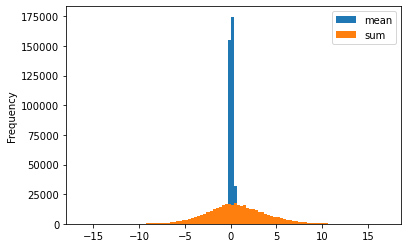

In [38]:
m1 = pd.DataFrame(result.mean(axis=1), columns=['mean'])
m1['sum'] = result.sum(axis=1)
m1.plot.hist(by='mean', bins=100)
m1

In [ ]:
tmp = filtered.fillna(0)
tmp_val_counts = tmp[~tmp.isin([0])].count(axis=1).sort_values()

print(tmp_val_counts)
tmp_tfs_occ = tmp_val_counts[tmp_val_counts >=16].index
result = filtered.loc[tmp_tfs_occ]

m1 = pd.DataFrame(result.mean(axis=1), columns=['mean'])
m1['sum'] = result.sum(axis=1)
m1.plot.hist(by='mean', bins=100)

## OLD implementation

In [ ]:
def prepare_diff_obj_dataframe(diff_obj: DiffCombObj) -> pd.DataFrame:
    
    # possible prefix names ['right-lobe-of-liver.10', 'right-lobe-of-liver.16']
    df = diff_obj.rules
    tissue_name_c1 , cluster_nr_c1  = diff_obj.prefixes[0].split('.')
    tissue_name_c2 , cluster_nr_c2  = diff_obj.prefixes[1].split('.')
    suff = ""
    if tissue_name_c1 == tissue_name_c2:
        suff += f"_{tissue_name_c1}"
    else:
        suff += f"_{tissue_name_c1}_{tissue_name_c2}"

    if cluster_nr_c1 == cluster_nr_c2:
        suff += f"_{cluster_nr_c1}"
    else:
        suff += f"_{cluster_nr_c1}_{cluster_nr_c2}"

    df['log2fc_class'] = df.apply(lambda x: 'negativ' if x[4] < 0 else 'positiv', axis=1)
    df.columns = [f'{x}{suff}' for x in df.columns]
    
    return df.copy(deep=True)


# Find the specific tf_cooccurences of a tissue that unique for the specific cluster in the tissue.
# 1. Diff analyse , 
# 2. Read in Diffanalyse for the specific cluster
# 3. Find tf-cooccurence of the diffob , which are occuring in each cluster
# Read in file Names of all analysis
files_main_mb= read_in_file_names_of_folder(rel_path=main_analysis_path)
print(f"Count of Files: {len(files_main_mb)}")
#print(f"Files: {files_main_mb}")

files_diff= read_in_file_names_of_folder(rel_path=differential_analysis_path)
print(f"Count of Files: {len(files_diff)}")

test = ""
for file_mb in files_main_mb:
    cluster_name = file_mb.split('.pkl')[0]
    print(cluster_name)
    diffs = list(filter(lambda x: cluster_name in x, files_diff))
    print(len(diffs))
    print(diffs)
    
    # Keeps the read in DiffCombObj diff_objects:
    diff_objects = []
    
    for diff in diffs:
        diff_obj = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}{diff}")
        diff_objects.append(diff_obj)
    
    erg = None
    for i in range(len(diff_objects)-1):
        
        if erg is None:
            obj_1= diff_objects[i]
            obj_2 = diff_objects[i + 1]
            df1 = prepare_diff_obj_dataframe(diff_obj = obj_1)
            df2 = prepare_diff_obj_dataframe(diff_obj = obj_2)
            
            erg = df1.merge(df2, how='outer', left_index=True, right_index=True)
        else:
            obj_2 = diff_objects[i + 1] 
            df2 = prepare_diff_obj_dataframe(diff_obj = obj_2)
            erg = erg.merge(df2, how='outer', left_index=True, right_index=True)
       
    test = erg
    erg.to_pickle(path=f"{answers_path}{cluster_name}.pkl")
    
print("Done")    
test.columns

In [ ]:
answer_file_names=read_in_file_names_of_folder(rel_path=answers_path)
print(answer_file_names)
cluster_dfs = []
df = None
for name in answer_file_names:
    df = pd.read_pickle(f"{answers_path}{name}")
    cluster_dfs.append(name)
    df = df

    #df.groupby(['class', 'value']).count()
    break;
filter_columns = list(filter(lambda x: 'log2fc_class' in x , df.columns))
#len(filter_columns)
filtered_df = df[df[filter_columns].notna().all(1)] #
filtered_df
df
#df3.iloc[:, 2:3]
#df = pd.read_pickle(f"{answers_path}right-lobe-of-liver.6.pkl")
#df = pd.read_pickle(f"{differential_analysis_selection_path}{right-lobe-of-liver.6.pkl}")


#original = CombObj().from_pickle(f"{main_analysis_path}right-lobe-of-liver.6.pkl")
#original.rules.loc[df.index]


In [ ]:
df = pd.read_pickle(f"{answers_path}right-lobe-of-liver.6.pkl")
selection = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}right-lobe-of-liver.10__right-lobe-of-liver.16.pkl")
selection_orig = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.10__right-lobe-of-liver.16.pkl")
selection_orig
selection

original = CombObj().from_pickle(f"{main_analysis_path}right-lobe-of-liver.6.pkl")
original.rules.loc[df.index]
selection.prefixes

### Try and Error section

In [ ]:
#mb_obj = CombObj().from_pickle(f"{main_analysis_path}right-lobe-of-liver.10.pkl")
obj_1 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.1.pkl")
obj_2 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.2.pkl")
obj_3 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.3.pkl")
obj_4 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.4.pkl")
obj_5 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.5.pkl")
obj_6 = DiffCombObj().from_pickle(f"{differential_analysis_path}right-lobe-of-liver.16__right-lobe-of-liver.6.pkl")
#mb_obj.rules
#type(diff_obj.rules)
#diff_obj2.rules
df_diff = pd.concat([obj_1.rules, obj_2.rules, obj_3.rules, obj_4.rules, obj_5.rules, obj_6.rules], join="inner")



#df_diff2 = pd.concat([diff_obj_1_1.rules,diff_obj2.rules, diff_obj1_2.rules])

unified_duplicates = df_diff[df_diff.duplicated(subset=['TF1', 'TF2'], keep='first')]

df_diff2 = pd.concat([unified_duplicates, diff_obj1_2.rules])

unified_duplicates2 = df_diff2[df_diff2.duplicated(subset=['TF1', 'TF2'], keep='first')]

#df_diff = df_diff.drop_duplicates(subset=['TF1', 'TF2'])
#unified_duplicates
#unified_duplicates
#unified_duplicates2
#diff_obj_1_1.rules
#unified_duplicates



In [ ]:
obj_1 = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}right-lobe-of-liver.16__right-lobe-of-liver.1.pkl")
obj_2 = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}right-lobe-of-liver.16__right-lobe-of-liver.2.pkl")

obj_1.simplify_rules()
obj_2.simplify_rules()
obj3 = obj_1.rules.merge(obj_2.rules, left_index=True, right_index=True, suffixes=(f"_{obj_1.prefixes[0]}_{obj_1.prefixes[1]}", f"_{obj_2.prefixes[0]}_{obj_2.prefixes[1]}"))
obj3


In [ ]:
#df['log2fc_class'] = df.apply(lambda x: 'negativ' if x[4] < 0 else 'positiv', axis=1)

#removedNAN = df[df.notna().all(1)]

#df2 = removedNAN[(removedNAN[filter_columns] > 0.0) | (removedNAN[filter_columns] < 0.0)]
#df2[df2.notna().all(1)]
#filtered_df = df[df[filter_columns].notna().all(1)]

In [ ]:
diff_obj_1_1.rules.loc['Foxd3-ONECUT2']
diff_obj2.rules.loc['Foxd3-ONECUT2']

In [ ]:
top30C = selectedC.select_top_rules(n=30)
top30C.rules.head(31)

In [ ]:
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo', 'fehler', 'nocheiner'],
                    'value': [1, 2, 3, 5,7,7]},
                   index=['my1', 'my2', 'my3', 'my4', 'my5', 'my6'])
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo','test'],
                    'value': [5, 6, 7, 8, 9]},
                  index=['my1', 'not2', 'my3', 'not4', 'my5'])
df3 = pd.DataFrame({'rkey': ['new', 'lol'],
                    'value': [5, 6]},
                  index=['my1', 'not2'])


#df1.merge(df2, left_on='lkey', right_on='rkey')
#erg = df1.merge(df2, left_index=True, right_index=True, suffixes=("_test", "_test2"))
erg = df1.merge(df2, how='outer', left_index=True, right_index=True, suffixes=("_x", "_y"))
#erg = erg.merge(df3, how='outer', left_index=True, right_index=True, suffixes=("_x", "_"))
erg


In [ ]:
df1

In [ ]:
df2

In [ ]:
df2.columns = [f'{x}_df2' for x in df2.columns]
df2

In [ ]:
[x+ 1 for x in df2.columns]

In [ ]:
df1['class'] = df1.apply(lambda x: 'niedrig' if x[1] < 5 else 'hoch', axis=1) 

In [ ]:
df1[df1['class'] == 'hoch']

In [ ]:
df1.groupby(['class', 'value']).count()

In [ ]:
df2

In [ ]:
df3.iloc[:, 2:3]

In [ ]:
top30C.plot_bubble()

In [ ]:
top30C.plot_network()

In [ ]:
selectedC.rules

In [ ]:
#### OLD 
# Find the specific tf_cooccurences of a tissue that unique for the specific cluster in the tissue.
# 1. Diff analyse , 
# 2. Read in Diffanalyse for the specific cluster
# 3. Find tf-cooccurence of the diffob , which are occuring in each cluster
# Read in file Names of all analysis
files_main_mb= read_in_file_names_of_folder(rel_path=main_analysis_path)
print(f"Count of Files: {len(files_main_mb)}")
#print(f"Files: {files_main_mb}")

files_diff= read_in_file_names_of_folder(rel_path=differential_analysis_path)
print(f"Count of Files: {len(files_diff)}")
#print(f"Files: {files_diff}")
test = ""
for file_mb in files_main_mb:
    cluster_name = file_mb.split('.pkl')[0]
    print(cluster_name)
    diffs = list(filter(lambda x: cluster_name in x, files_diff))
    print(len(diffs))
    print(diffs)
    
    # Keeps the read in DiffCombObj diff_objects:
    diff_objects = []
    
    for diff in diffs:
        diff_obj = DiffCombObj().from_pickle(f"{differential_analysis_selection_path}{diff}")
        diff_objects.append(diff_obj)
    
    # erste DiffObj dataframe 
    initial_df = diff_objects[0].rules
    
    #has neg and pos foldchange
    cross_product_merged = initial_df
    
    # only pos foldchange
    pos_merged = initial_df[initial_df.iloc[:,4] > 0.00]
    
    # only neg foldchange
    neg_merged = initial_df[initial_df.iloc[:,4] < 0.00]
    for i in range(len(diff_objects)-1):
        obj_1= diff_objects[i]
        obj_2 = diff_objects[i + 1]
            
        # cross_product merge rules-dataframe by index (TF´s)
        cross_product = cross_product_merged.merge(obj_2.rules, left_index=True, right_index=True, suffixes=(f"_{obj_1.prefixes[0]}_{obj_1.prefixes[1]}", f"_{obj_2.prefixes[0]}_{obj_2.prefixes[1]}"))
        cross_product_merged = cross_product.copy(deep=True)
        
        # pos merge rules-dataframe by index (TF´s)
        obj2_df_pos = obj_2.rules[obj_2.rules.iloc[:,4] > 0.00]
        df_pos_merged = pos_merged.merge(obj2_df_pos, left_index=True, right_index=True, suffixes=(f"_{obj_1.prefixes[0]}_{obj_1.prefixes[1]}", f"_{obj_2.prefixes[0]}_{obj_2.prefixes[1]}"))
        pos_merged = df_pos_merged.copy(deep=True)
        
        # neg merge rules-dataframe by index (TF´s)
        obj2_df_neg = obj_2.rules[obj_2.rules.iloc[:,4] < 0.00]
        df_neg_merged = neg_merged.merge(obj2_df_neg, left_index=True, right_index=True, suffixes=(f"_{obj_1.prefixes[0]}_{obj_1.prefixes[1]}", f"_{obj_2.prefixes[0]}_{obj_2.prefixes[1]}"))
        neg_merged = df_neg_merged.copy(deep=True)
        
        
    cross_product_merged.to_pickle(path=f"{answers_path}{cluster_name}_cross.pkl")
    pos_merged.to_pickle(path=f"{answers_path}{cluster_name}_pos.pkl")
    neg_merged.to_pickle(path=f"{answers_path}{cluster_name}_neg.pkl")
    
print("Done")    
test
